# Previsão de Potencial de Falha de Maquinário

O objetivo do presente projeto é identificar quais máquinas apresentam potencial de falha, tendo como base dados extraídos de sensores durante o processo de manufatura.

## 0. Importação de Bibliotecas e *Helper Functions*

In [155]:
import random
import warnings
import numpy   as np
import pandas  as pd
import seaborn as sns
from boruta                  import BorutaPy
from lightgbm                import LGBMClassifier
from matplotlib              import pyplot as plt
from sklearn.svm             import LinearSVC
from sklearn.metrics         import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.ensemble        import ExtraTreesClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.multiclass      import OneVsRestClassifier
from sklearn.naive_bayes     import GaussianNB
from sklearn.linear_model    import LogisticRegression
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, RobustScaler
from imblearn.over_sampling  import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold

In [156]:
def personal_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['font.size'] = 20
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.float_format', lambda x:'%.2f' % x)
    sns.set()
    sns.set(rc = {'figure.figsize':(12,6)})
    warnings.filterwarnings('ignore')

personal_settings()

In [342]:
def failure_rate(df, atribute):
  '''Função usada na etapa de validação de hipóteses, para calcular o percentual de falha em razão de algum atributo do conjunto de dados'''
  df_result = pd.DataFrame()

  for i in df[atribute].unique():
    mask_i = df[atribute] == i
    maskf = df['result'] == 'failure'
    masknf = df['result'] == 'no_failure'
    failure = (df[mask_i & maskf].shape[0] / df[mask_i & masknf].shape[0]) * 100

    df_temp = pd.DataFrame({atribute: i, 
              'failure_rate (%)': failure}, index=[0])
    df_result = pd.concat([df_result, df_temp])

  df_result = df_result.sort_values('failure_rate (%)', ascending=False)
  
  return df_result

def model_avaliation(data, y_hat, y_val, model_name):
    '''Função para preparar os dados, calcular o precision, recall e accuracy do modelo e retornar os valors em um dataframe'''
    df = data.copy()
    df['classification'] = y_hat.tolist()
    
    precision = precision_score(y_val, y_hat, average='macro')
    recall = recall_score(y_val, y_hat, average='macro')
    f1score = f1_score(y_val, y_hat, average='macro')
    accuracy = accuracy_score(y_val, y_hat)
    
    return pd.DataFrame({'Precision': precision,
                        'Recall': recall,
                        'F1-Score': f1score,
                        'Accuracy': accuracy}, index=[model_name])

def cross_validation(model_name, model, x_train, y_train, verbose=False):
    '''Função para realizar o Cross Validation dos modelos de Machine Learning'''
    precision_list = []
    recall_list    = []
    f1_list        = []
    
    kfolds = StratifiedKFold(n_splits = 5, shuffle=True, random_state=5)
    
    for cv_train, cv_val in kfolds.split(x_train, y_train):
        
        # Cross-Validation Train
        xtrain_val = x_train.iloc[cv_train]
        ytrain_val = y_train.iloc[cv_train]
        
        oversample = SMOTE()
        x_train_over, y_train_over = oversample.fit_resample(xtrain_val, ytrain_val)

        # Cross-Validation Validation
        xval = x_train.iloc[cv_val]
        yval = y_train.iloc[cv_val]
        
        # Treinamento do modelo
        model.fit(x_train_over, y_train_over)

        # Previsão
        yhat = model.predict(xval)
        
        # Preparando os Dados
        data = xval.copy()
        data['failure_type'] = yval.copy()

        # Score
        data['classification'] = yhat.tolist()

        # Performance
        precision = precision_score(yval, yhat, average='macro')
        precision_list.append(precision)
        
        recall = recall_score(yval, yhat, average='macro')
        recall_list.append(recall)

        f1score = f1_score(yval, yhat, average='macro')
        f1_list.append(f1score)
        
        acc = accuracy_score(yval, yhat)
        
    return pd.DataFrame({'Precision - CV': np.round(np.mean(precision_list), 3),
                         'Recall - CV': np.round(np.mean(recall_list), 3),
                         'F1-Score - CV': np.round(np.mean(f1_list), 3),
                         'Accuracy - CV': np.round(np.mean(acc), 3)},index=[model_name])

## 1. Carregando os Dados

Simples importação e exibição dos 05 primeiros registros do conjunto de dados, para ter um contato inicial.

In [158]:
df_raw = pd.read_csv('../data/desafio_manutencao_preditiva_treino.csv')
df_raw.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,M,298.10,308.60,1551,42.80,0,No Failure
1,2,L47181,L,298.20,308.70,1408,46.30,3,No Failure
2,5,L47184,L,298.20,308.70,1408,40.00,9,No Failure
3,6,M14865,M,298.10,308.60,1425,41.90,11,No Failure
4,7,L47186,L,298.10,308.60,1558,42.40,14,No Failure


## 2. Descrição dos Dados

Como boa prática, sempre ao iniciar uma nova seção do projeto, crio uma cópia do dataframe anterior. 

In [159]:
df1 = df_raw.copy()

### 2.1 Dicionário de Colunas

In [160]:
df1.columns

Index(['udi', 'product_id', 'type', 'air_temperature_k',
       'process_temperature_k', 'rotational_speed_rpm', 'torque_nm',
       'tool_wear_min', 'failure_type'],
      dtype='object')

Criar esse dicionário de colunas vai facilitar para entender o que os valores de cada atributo representam.

|    Atributos         |                         Significado                          |
| :------------------: | :----------------------------------------------------------: |
|udi                   |identificador único|
|product_id            |identificador único do produto|
|type                  |tipo do produto de acordo com sua qualidade (L para *low*, M para *medium* e H para *high*)|
|air_temperature_k     |temperatura do ar em Kelvins|
|process_temperature_k |temperatura do processo em Kelvins|
|rotational_speed_rpm  |velocidade rotacional em Rotações por Minuto|
|torque_nm             |medição do torque em Newton metro|
|tool_wear_min         |desgaste da ferramenta utilizada no processo em minutos|
|failure_type (variável resposta) |indica se a máquina falhou ou não (*No Failure*, *Power Failure*, *Tool Wear Failure*, *Overstrain Failure*, *Random Failures*, *Heat Dissipation Failure*) |

### 2.2 Dimensões

In [161]:
print(f'Número de registros/linhas:   {df1.shape[0]}')
print(f'Número de atributos/colunas: {df1.shape[1]}')

Número de registros/linhas:   6667
Número de atributos/colunas: 9


### 2.3 Tipos de Dados

In [162]:
df1.dtypes

udi                        int64
product_id                object
type                      object
air_temperature_k        float64
process_temperature_k    float64
rotational_speed_rpm       int64
torque_nm                float64
tool_wear_min              int64
failure_type              object
dtype: object

Olhando para os tipos de dados de cada atributo, bem como para o conjunto de dados em si, não vejo necessidade de alterar algum tipo de dado.

### 2.4 Valores Nulos

In [163]:
df1.isna().sum()

udi                      0
product_id               0
type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
failure_type             0
dtype: int64

Não temos nenhum valor nulo no conjunto de dados, então não preciso me preocupar em remover ou preencher valores faltantes.

### 2.5 Registros Duplicados

In [164]:
df1.duplicated().sum()

0

Também não temos nenhum registro duplicado, então não preciso remove-los.

### 2.6 Análise Estatística Descritiva

#### 2.6.1 Atributos Numéricos

In [165]:
df1_numerical = df1.select_dtypes(include= ['int64', 'float64'])
df1_numerical.head()

,udi,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
0,1,298.10,308.60,1551,42.80,0
1,2,298.20,308.70,1408,46.30,3
2,5,298.20,308.70,1408,40.00,9
3,6,298.10,308.60,1425,41.90,11
4,7,298.10,308.60,1558,42.40,14


Verificando o dicionário de colunas, vou remover a coluna *udi*, já que somente corresponde a um identificador único da medição do sensor.

In [166]:
df1_numerical = df1_numerical.drop('udi', axis=1)
df1_numerical.head()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
0,298.10,308.60,1551,42.80,0
1,298.20,308.70,1408,46.30,3
2,298.20,308.70,1408,40.00,9
3,298.10,308.60,1425,41.90,11
4,298.10,308.60,1558,42.40,14


Agora vou calcular algumas medidas de estatística para ter uma noção da concentração e distribuição de valores para cada um desses atributos.

In [167]:
df_mean     = pd.DataFrame(df1_numerical.apply(np.mean)).T
df_median   = pd.DataFrame(df1_numerical.apply(np.median)).T
df_std      = pd.DataFrame(df1_numerical.apply(np.std)).T
df_min      = pd.DataFrame(df1_numerical.apply(min)).T
df_max      = pd.DataFrame(df1_numerical.apply(max)).T
df_range    = pd.DataFrame(df1_numerical.apply(lambda x: x.max() - x.min())).T
df_skew     = pd.DataFrame(df1_numerical.apply(lambda x: x.skew())).T
df_kurtosis = pd.DataFrame(df1_numerical.apply(lambda x: x.kurtosis())).T

In [168]:
df_desc = pd.concat([df_min, df_max, df_range, df_mean, df_median, df_std, df_skew, df_kurtosis]).T.reset_index()
df_desc.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
df_desc

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,air_temperature_k,295.30,304.50,9.20,299.99,300.00,1.99,0.13,-0.82
1,process_temperature_k,305.70,313.80,8.10,309.99,310.00,1.49,0.02,-0.51
2,rotational_speed_rpm,1168.00,2886.00,1718.00,1537.42,1503.00,177.17,1.95,7.31
3,torque_nm,3.80,76.60,72.80,40.06,40.20,9.95,0.01,0.01
4,tool_wear_min,0.00,251.00,251.00,108.10,108.00,63.36,0.02,-1.16


Interpretando a tabela: 
- min: é o valor mínimo registrado em cada atributo numérico.
- max: é o valor máximo registrado em cada atributo numérico.
- range: é o intervalo entre o valor máximo e o valor mínimo de cada atributo numérico. 
- mean: é o valor médio de cada atributo numérico. 
- median: é o valor mediano de cada atributo numérico (com os valores ordenados de forma crescente, a mediana é o valor 'do meio', também correspondendo ao 50º percentil e ao 2º quartil).
- std: é o desvio padrão - a distância média dos valores em relação à média.
- skew (ou skewness): representa o quanto a distribuição dos dados está assimétrica em relação à média.
- kurtosis: representa a distribuição dos valores em torno da média, evidenciando uma distribuição de caudas longas. 

#### 2.6.2 Atributos Categóricos

In [169]:
df1_categorical = df1.select_dtypes(exclude=['int64', 'float64'])
df1_categorical.head()

,product_id,type,failure_type
0,M14860,M,No Failure
1,L47181,L,No Failure
2,L47184,L,No Failure
3,M14865,M,No Failure
4,L47186,L,No Failure


In [170]:
print(f'Número de registros: {df1_categorical.shape[0]}')
print('Número de product_ids únicos: {}'.format(df1_categorical['product_id'].nunique()))

Número de registros: 6667
Número de product_ids únicos: 6667


Aqui podemos ver que cada registro do conjunto de dados corresponde a um produto com id único.

In [171]:
df1_categorical['type'].value_counts()

L    4022
M    1987
H     658
Name: type, dtype: int64

Aqui já podemos ver que temos mais produtos do tipo 'L' e menos produtos do tipo 'H' sendo manufaturados.

In [172]:
df1_categorical['failure_type'].value_counts()

No Failure                  6435
Heat Dissipation Failure      75
Power Failure                 63
Overstrain Failure            52
Tool Wear Failure             30
Random Failures               12
Name: failure_type, dtype: int64

Por fim, quanto à variável alvo, a gigantesca maioria dos processos de produção dos produtos não houve falha. 

Isso pode configurar um problema de desbalanceamento de classes na etapa posterior de Machine Learning.

## 3. Análise Exploratória dos Dados

In [173]:
df2 = df1.copy()

### 3.1 Análise Univariada

#### 3.1.1 Variável Resposta

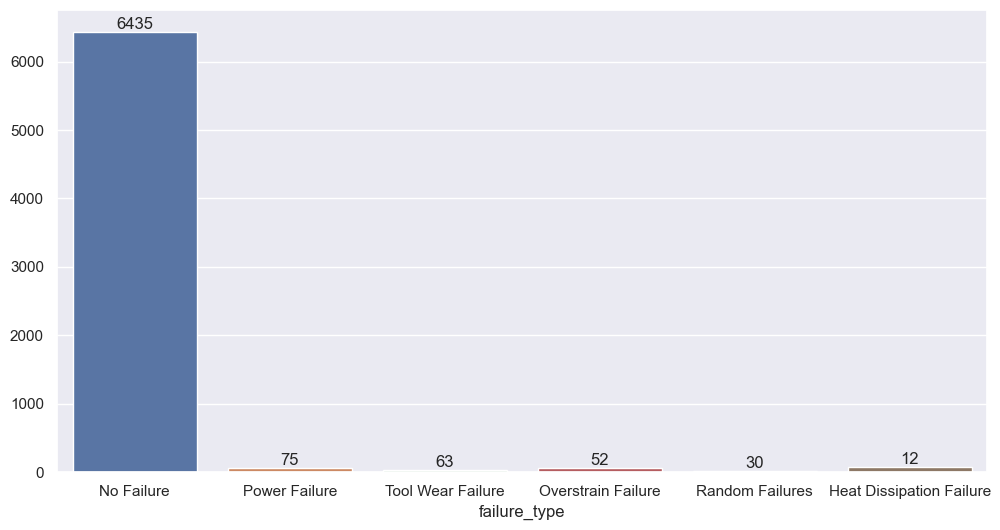

In [174]:
a = sns.countplot(x='failure_type', data=df2)
values = df2['failure_type'].value_counts().values
a.bar_label(container=a.containers[0], labels=values)
a.set(ylabel=None);

Conforme já dito acima, esse desbalanceamento de classes pode afetar a etapa posterior de Machine Learning.

#### 3.1.2 Variáveis Numéricas

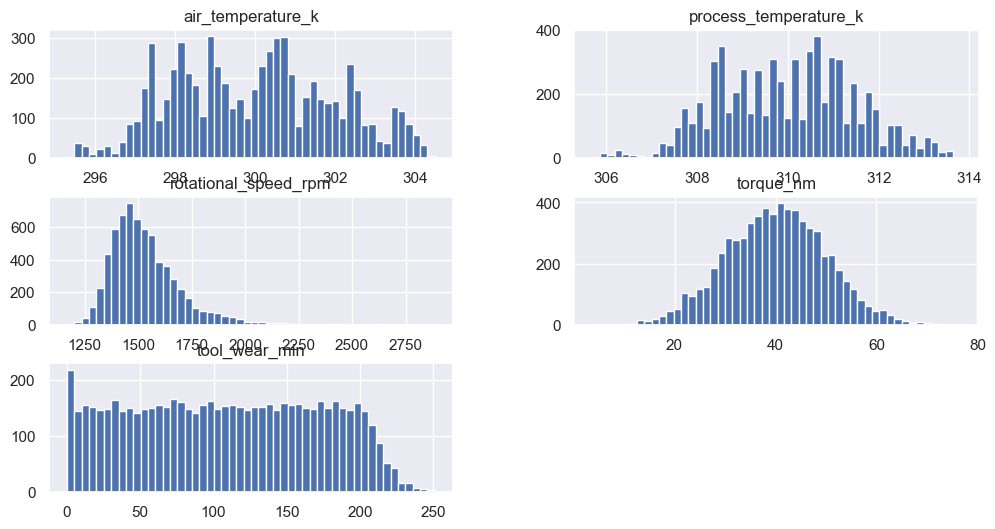

In [175]:
df1_numerical.hist(bins=50);

Aqui podemos ter uma noção geral de distribuição de valores das variáveis numéricas. 

Por exemplo, a variável *torque_nm* apresenta uma distribuição praticamente normal, o que devemos levar em conta na etapa posterior de Preparação dos Dados. 

#### 3.1.3 Variáveis Categóricas

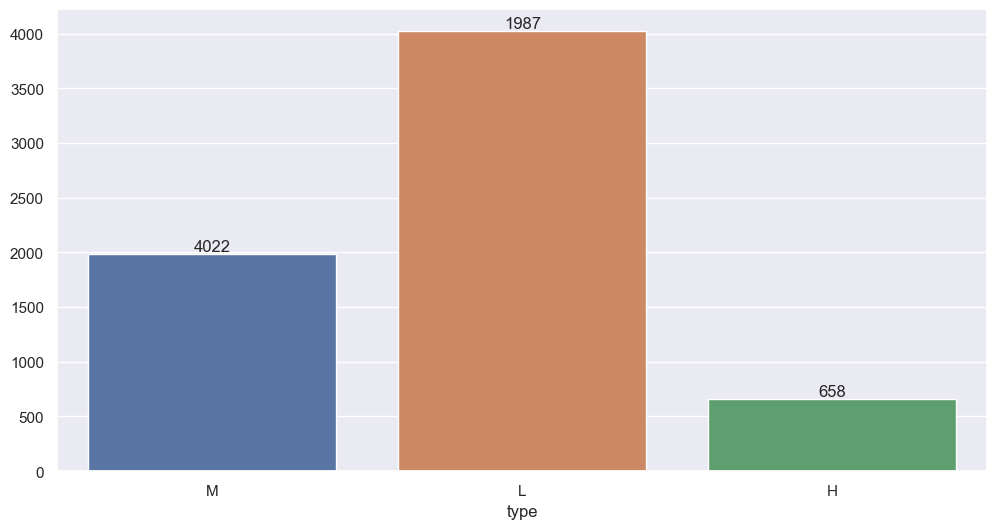

In [176]:
a = sns.countplot(x='type', data=df2)
values = df2['type'].value_counts().values
a.bar_label(container=a.containers[0], labels=values)
a.set(ylabel=None);

Aqui é só uma representação gráfica daquilo que já foi exposto acima, de que a maioria dos produtos produzidos pelas máquinas são do tipo 'L', e a minoria são do tipo 'H'.

### 3.2 Análise Bivariada - Validação de Hipóteses

Nessa etapa, vou criar algumas hipóteses para serem validadas, tendo como base os dados disponíveis e alguns atributos do conjunto de dados, com o objetivo de extrair alguma informação ou *insight*. 

Hipóteses: 
- H1: Em comparação com os tipos de produtos 'L' e 'M', a produção de produtos do tipo 'H' acarreta em mais falhas.
- H2: Processos que exigem temperaturas mais altas fazem com que as máquinas falhem mais. 
- H3: Processos que exigem mais RPM fazem com que as máquinas falhem mais. 

#### H1. Em comparação com os tipos de produtos 'L' e 'M', a produção de produtos do tipo 'H' acarreta em mais falhas.

In [177]:
h1_df = df2.copy()

In [178]:
h1_df['type'].value_counts(normalize=True)

L   0.60
M   0.30
H   0.10
Name: type, dtype: float64

Primeiro temos que levar em consideração que existem produtos do tipo 'H' no conjunto de dados, representando apenas 10% dos registros.

Assim, uma forma de validarmos essa hipótese é verificar a porcentagem de falhas em relação ao total de processos para cada tipo de produto.

In [179]:
h1_df['result'] = h1_df.apply(lambda x: 'no_failure' if x['failure_type'] == 'No Failure' else 'failure', axis=1)
h1_df.sample()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,result
2397,3564,M18423,M,301.80,310.70,1465,35.80,82,No Failure,no_failure


In [180]:
df_result = failure_rate(h1_df, 'type')
df_result

,type,failure_rate (%)
0,L,4.17
0,M,2.79
0,H,2.65


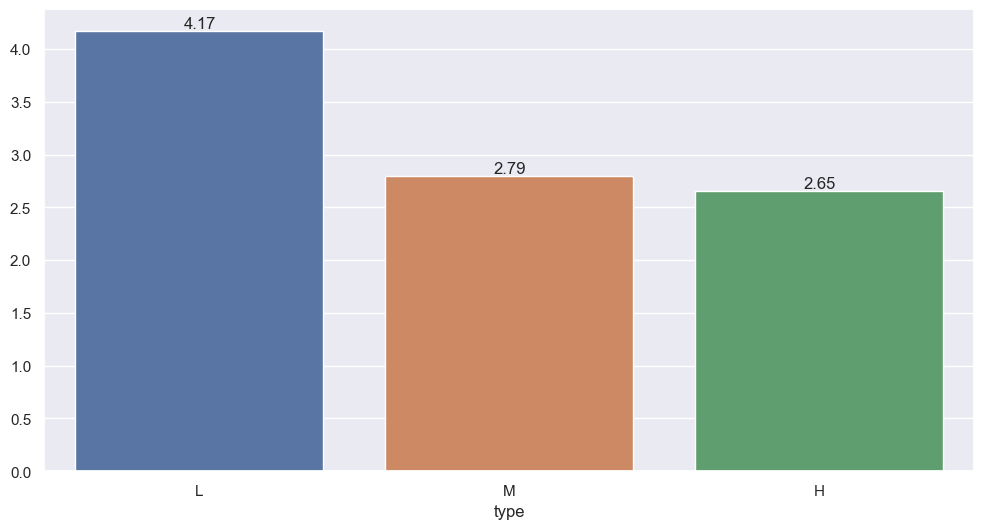

In [181]:
a = sns.barplot(data = df_result, x='type', y='failure_rate (%)')
values = df_result['failure_rate (%)'].values.round(2)
a.bar_label(container=a.containers[0], labels=values)
a.set(ylabel=None);

**FALSA**: a produção de produtos do tipo 'L', proporcionalmente, acarretam em mais falhas nas máquinas.

#### H2. Processos que exigem temperaturas mais altas fazem com que as máquinas falhem mais. 

In [182]:
h2_df = df2.copy()

In [183]:
h2_df['process_temperature_k'].describe()

count   6667.00
mean     309.99
std        1.49
min      305.70
25%      308.80
50%      310.00
75%      311.10
max      313.80
Name: process_temperature_k, dtype: float64

Aqui podemos ver que a temperatura dos processos variam entre 305.70 e 313.80. 

A mediana está em 310.00, então vou considerar como temperatura alta valores que estiverem acima dessa medida.

E da mesma forma que na hipótese anterior, vou verificar a porcentagem de falhas em relação ao total de processos para cada temperatura (alta ou baixa). 

In [184]:
h2_df['result'] = h2_df.apply(lambda x: 'no_failure' if x['failure_type'] == 'No Failure' else 'failure', axis=1)
h2_df['process_temp'] = h2_df.apply(lambda x: 'high' if x['process_temperature_k'] > 310 else 'low', axis=1)
h2_df.sample()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,result,process_temp
4364,6549,L53728,L,301.40,310.80,1770,24.10,112,No Failure,no_failure,high


In [185]:
df_result = failure_rate(h2_df, 'process_temp')
df_result

,process_temp,failure_rate (%)
0,high,4.82
0,low,2.42


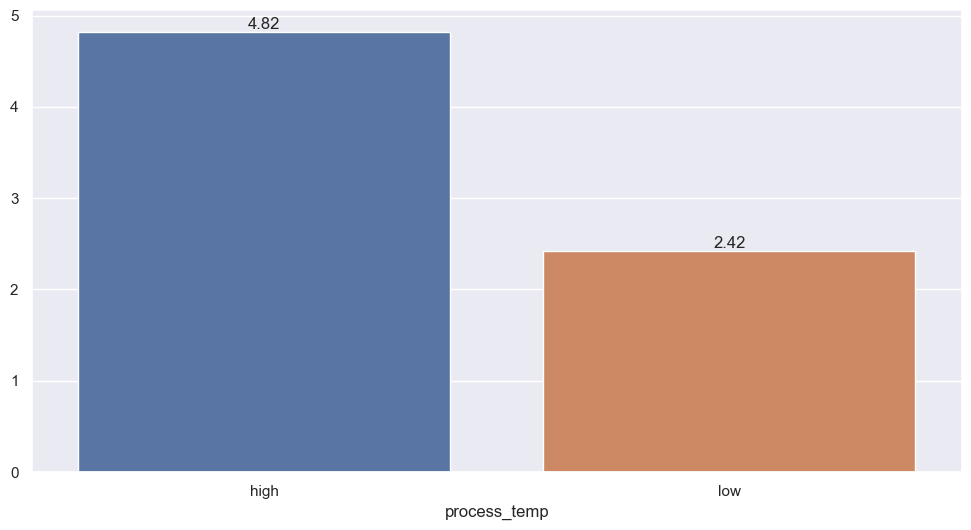

In [186]:
a = sns.barplot(data = df_result, x='process_temp', y='failure_rate (%)')
values = df_result['failure_rate (%)'].values.round(2)
a.bar_label(container=a.containers[0], labels=values)
a.set(ylabel=None);

**VERDADEIRA**: a produção de produtos que exigem uma temperatura mais alta (acima de 310.00 K), acarretam em mais falhas nas máquinas.

#### H3. Processos que exigem mais RPM fazem com que as máquinas falhem mais. 

In [187]:
h3_df = df2.copy()

In [188]:
h3_df['rotational_speed_rpm'].describe()

count   6667.00
mean    1537.42
std      177.18
min     1168.00
25%     1422.50
50%     1503.00
75%     1612.00
max     2886.00
Name: rotational_speed_rpm, dtype: float64

Aqui podemos ver que a rotação por minuto dos processos variam entre 1168.00 e 2886.00.

A mediana está em 1503.00, então vou considerar como RPM alta valores que estiverem acima dessa medida.

E da mesma forma que nas hipóteses anteriores, vou verificar a porcentagem de falhas em relação ao total de processos para RPM (alta ou baixa). 

In [189]:
h3_df['result'] = h3_df.apply(lambda x: 'no_failure' if x['failure_type'] == 'No Failure' else 'failure', axis=1)
h3_df['rotational_speed'] = h3_df.apply(lambda x: 'high' if x['rotational_speed_rpm'] > 1503 else 'low', axis=1)
h3_df.sample()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,result,rotational_speed
3169,4736,L51915,L,303.20,311.50,1544,42.50,227,No Failure,no_failure,high


In [190]:
df_result = failure_rate(h3_df, 'rotational_speed')
df_result

,rotational_speed,failure_rate (%)
0,low,5.97
0,high,1.34


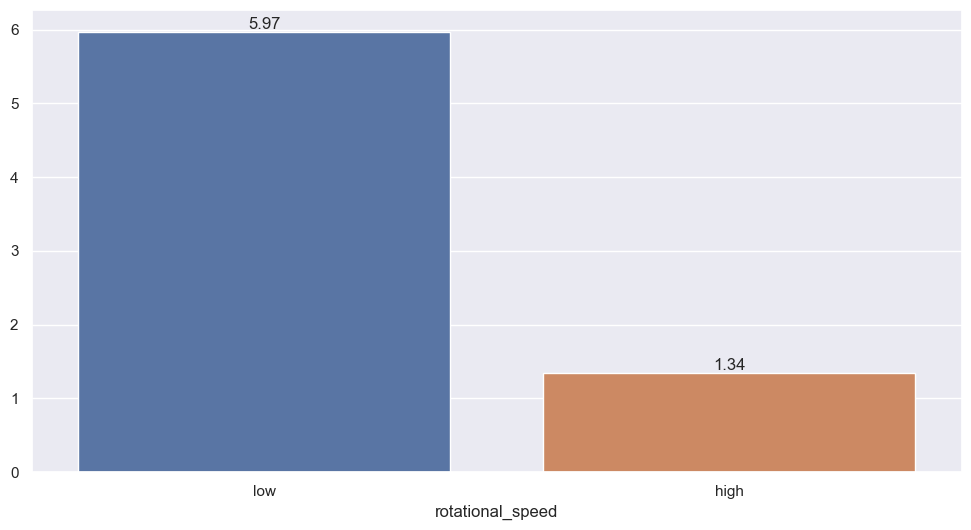

In [191]:
a = sns.barplot(data = df_result, x='rotational_speed', y='failure_rate (%)')
values = df_result['failure_rate (%)'].values.round(2)
a.bar_label(container=a.containers[0], labels=values)
a.set(ylabel=None);

**FALSA**: a produção de produtos que exigem RPM mais alta (acima de 1503.00 RPM), acarretam em menos falhas nas máquinas. 

#### Resumo das Hipóteses

| Número |                         Hipótese                                                                              |   Conclusão   |
| :----: | :-----------------------------------------------------------------------------------------------------------: | :-----------: |
| H1     | Em comparação com os tipos de produtos 'L' e 'M', a produção de produtos do tipo 'H' acarreta em mais falhas. | FALSA |
| H2     | Processos que exigem temperaturas mais altas fazem com que as máquinas falhem mais.                           | VERDADEIRA |
| H3     | Processos que exigem mais RPM fazem com que as máquinas falhem mais.                                          | FALSA |

### 3.3 Análise Multivariada

#### 3.3.1 Variáveis Numéricas

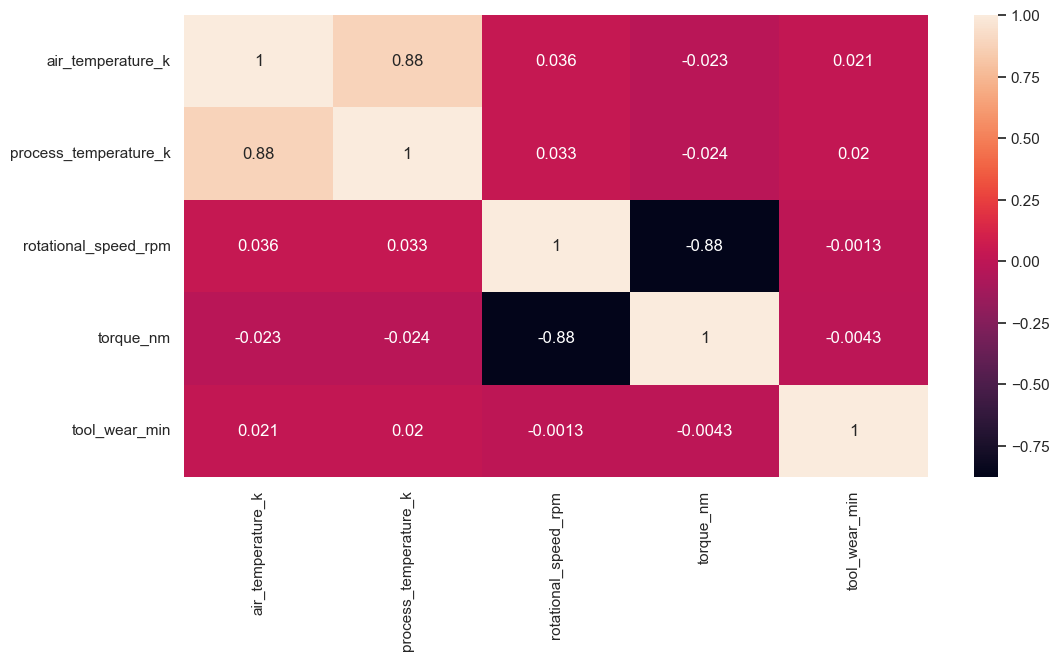

In [192]:
correlation = df1_numerical.corr(method='pearson')
sns.heatmap(correlation, annot=True);

Aqui temos uma matriz de correlação entre as variáveis numéricas, com valores indo de 1 (variáveis positivamente relacionadas) a -1 (variáveis negativamente relacionadas). 

Podemos ver que as variáveis *process_temperature_k* e *air_temperature_k* são positivamente relacionadas, enquanto as variáveis *torque_nm* e *rotational_speed_rpm* são negativamente relacionadas.

## 4. Preparação dos Dados

In [193]:
df3 = df2.copy()

### 4.1 Separando o Conjunto de Dados

Primeiro de tudo, vou separar o conjunto de dados entre Treino e Validação. Isso evita eventual vazamento de dados ('passagem' de informações do conjunto de Dados para o de Validação).

Os dados de Treino servirão de base para treino dos algoritmos de ML, enquanto os de Validação servirão para medir a performance do algoritmo.

In [194]:
x = df3.drop('failure_type', axis=1)
y = df3['failure_type'].copy()

Vou usar uma função da biblioteca *sklearn* para fazer essa separação dos dados.

In [195]:
x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=0.20)

In [196]:
df_train = pd.concat([x_train, y_train], axis=1)
df_train.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
4433,6651,L53830,L,301.60,310.40,1561,35.30,156,No Failure
3685,5512,L52691,L,302.80,312.10,1958,20.30,56,No Failure
1770,2642,H32055,H,299.80,309.50,1420,46.70,136,No Failure
2802,4183,L51362,L,302.40,310.70,1362,54.80,155,Heat Dissipation Failure
5218,7838,L55017,L,300.20,311.50,1685,31.00,193,No Failure


In [197]:
print(x_train.shape, y_train.shape)
print(x_validation.shape, y_validation.shape)

(5333, 8) (5333,)
(1334, 8) (1334,)


Aqui podemos ver quantos registros estão em cada conjunto de dados (Treino e Validação).

Feita a 'divisão' do conjunto de dados, hora de ajustar os dados para a fase de Machine Learning.

### 4.2 Normalização

#### 4.2.1 *torque_nm*

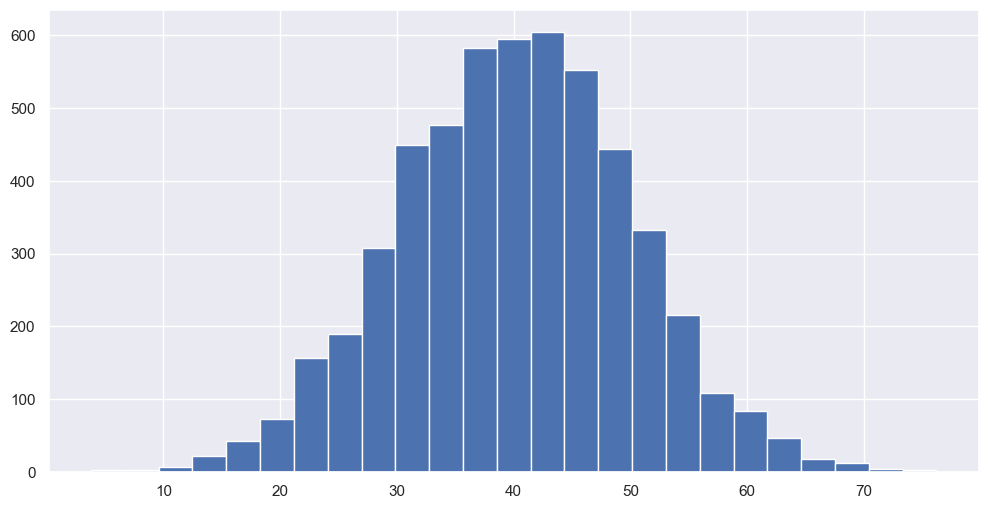

In [200]:
df_train['torque_nm'].hist(bins=25);

Como já visto anteriormente, essa variável possui uma distribuição normal, de modo que vou submetê-la ao procedimento de Normalização (*Standardization*). 

Esse procedimento reescala a média dos valores para 0 com desvio-padrão igual a 1.

In [201]:
ss_torque = StandardScaler()
df_train['torque_nm'] = ss_torque.fit_transform(df_train[['torque_nm']].values)
df_train['torque_nm'].head()

4433   -0.49
3685   -2.00
1770    0.66
2802    1.47
5218   -0.92
Name: torque_nm, dtype: float64

### 4.3 *Rescaling*

Para verificar que procedimentos vou utilizar para as outra variáveis numéricas, vou visualizar a distribuição dos valores de cada uma através de um boxplot.

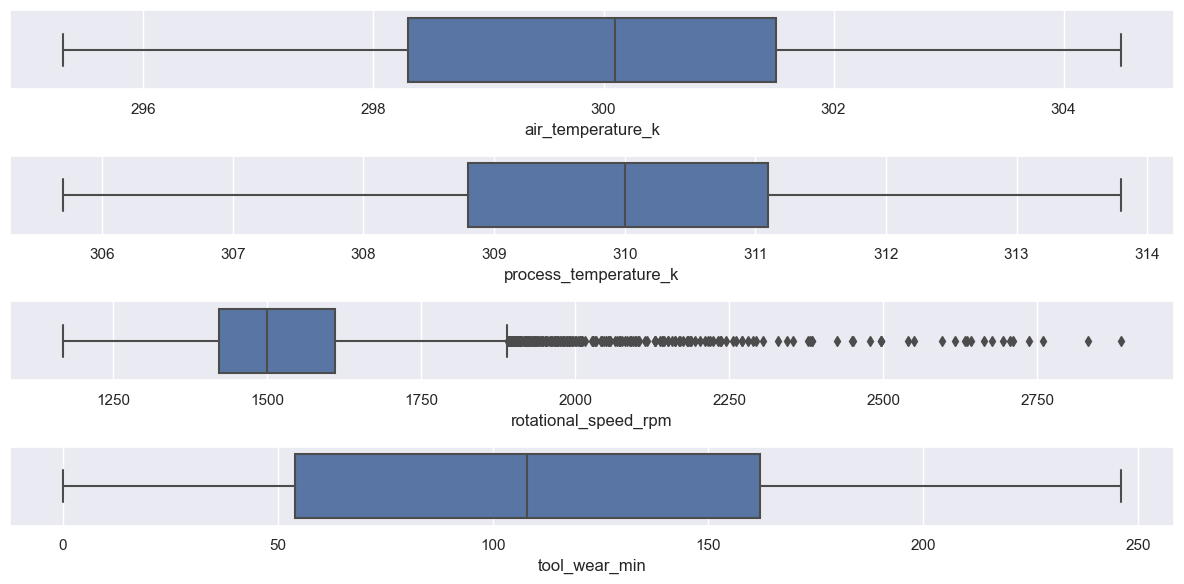

In [202]:
plt.subplot(4, 1, 1)
sns.boxplot(data=df_train, x='air_temperature_k')

plt.subplot(4, 1, 2)
sns.boxplot(data=df_train, x='process_temperature_k')

plt.subplot(4, 1, 3)
sns.boxplot(data=df_train, x='rotational_speed_rpm')

plt.subplot(4, 1, 4)
sns.boxplot(data=df_train, x='tool_wear_min')

plt.tight_layout();

#### 4.3.1 *air_temperature_k*

Essa variável não contém outliers (pontos fora das extremidades, ou *whiskers*, do gráfico), assim vou utilizar o *Min-Max Scaler*. 

Esse procedimento pega cada valor da variável, subtrai da média e divide pelo intervalo de valores (intervalo sendo o resultado da subtração entre valor máximo e mínimo). 

In [203]:
mms_air_temperature = MinMaxScaler()
df_train['air_temperature_k'] = mms_air_temperature.fit_transform(df_train[['air_temperature_k']].values)

#### 4.3.2 *process_temperature_k*

Aqui também vou usar o *Min-Max Scaler*, pelos mesmos motivos da variável acima. 

In [204]:
mms_process_temperature = MinMaxScaler()
df_train['process_temperature_k'] = mms_process_temperature.fit_transform(df_train[['process_temperature_k']].values)

#### 4.3.3 *rotational_speed_rpm*

Como essa variável contém outliers, vou usar o *Robust Scaler* para ajustar os dados. 

Esse procedimento pega cada valor da variável, subtrai do 1º Quartil e divide pelo IQR (3º Quartil - 1º Quartil). 

In [205]:
rs_rotational_speed = RobustScaler()
df_train['rotational_speed_rpm'] = rs_rotational_speed.fit_transform(df_train[['rotational_speed_rpm']].values)

#### 4.3.4 *tool_wear_min*

Por fim, também vou usar o *Min-Max Scaler* para essa variável.

In [206]:
mms_tool_wear = MinMaxScaler()
df_train['tool_wear_min'] = mms_tool_wear.fit_transform(df_train[['tool_wear_min']].values)

#### 4.3.5 Verificando o *rescaling*

In [207]:
df_train[['air_temperature_k', 'process_temperature_k', 'rotational_speed_rpm', 'tool_wear_min']].head()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,tool_wear_min
4433,0.68,0.58,0.33,0.63
3685,0.82,0.79,2.45,0.23
1770,0.49,0.47,-0.43,0.55
2802,0.77,0.62,-0.74,0.63
5218,0.53,0.72,0.99,0.78


### 4.4 Transformação

#### 4.4.1 *Encoding* - Transformação de Variáveis Categóricas em Numéricas

##### *type*

Para essa variável categórica, vou usar o *Ordinal Encoding*, atribuindo números para cada valor de forma hierárquica.

In [208]:
type_dict = {'L': 0, 'M': 1, 'H': 2}
df_train['type'] = df_train['type'].map(type_dict)
df_train['type'].unique()

array([0, 2, 1], dtype=int64)

##### *failure_type*

Para a variável resposta, também vou usar o *Ordinal Encoding* para atribuir números para cada tipo de falha. 

In [209]:
df_train['failure_type'].unique()

array(['No Failure', 'Heat Dissipation Failure', 'Overstrain Failure',
       'Random Failures', 'Tool Wear Failure', 'Power Failure'],
      dtype=object)

In [210]:
failure_dict = {'No Failure': 0, 'Heat Dissipation Failure': 1, 'Random Failures': 2, 'Power Failure': 3, 'Tool Wear Failure': 4, 'Overstrain Failure': 5}
df_train['failure_type'] = df_train['failure_type'].map(failure_dict)
df_train['failure_type'].unique()

array([0, 1, 5, 2, 4, 3], dtype=int64)

Aqui vou criar um novo conjunto de dados contendo somente os valores da variável resposta para usar posteriormente na etapa de Seleção de *Features*

In [211]:
y_train_b = df_train['failure_type'].copy()

### 4.5 Preparação dos Dados - Conjunto de Validação

Aqui vou preparar os dados de Validação com base na preparação e transformações feitas em cima dos dados de Treino.

In [212]:
x_validation.loc[:, 'type'] = x_validation.loc[:, 'type'].map(type_dict)
x_validation.loc[:, 'air_temperature_k'] = mms_air_temperature.transform(x_validation[['air_temperature_k']].values)
x_validation.loc[:, 'process_temperature_k'] = mms_process_temperature.transform(x_validation[['process_temperature_k']].values)
x_validation.loc[:, 'rotational_speed_rpm'] = rs_rotational_speed.transform(x_validation[['rotational_speed_rpm']].values)
x_validation.loc[:, 'torque_nm'] = ss_torque.transform(x_validation[['torque_nm']].values)
x_validation.loc[:, 'tool_wear_min'] = mms_tool_wear.transform(x_validation[['tool_wear_min']].values)
y_validation = y_validation.map(failure_dict)

In [213]:
x_validation.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
3068,4595,M19454,1,0.84,0.68,-0.60,0.13,0.41
1929,2864,L50043,0,0.58,0.46,-0.16,0.40,0.99
3481,5220,L52399,0,0.92,0.90,-0.72,1.99,0.83
5650,8473,L55652,0,0.35,0.49,0.72,-0.24,0.32
4134,6210,L53389,0,0.59,0.60,-0.50,0.04,0.35


In [214]:
y_validation.head()

3068    0
1929    0
3481    5
5650    0
4134    0
Name: failure_type, dtype: int64

## 5 Seleção de Variáveis - *Feature Selection*

In [215]:
df4 = df_train.copy()

### 5.1 Seleção das Variáveis Usando o Boruta

Primeiro, vou tentar usar o método de Seleção de Variáveis por Subset (*Wrapper Method*), através do algoritmo Boruta.

Para tanto, preciso transformar o conjunto de dados em vetores.

In [60]:
x_train_n = df4.drop(['udi', 'product_id', 'failure_type'], axis=1).values
y_train_n = y_train_b.values.ravel()

O modelo que vou utilizar para a Seleção de Variáveis pelo Boruta será o RandomForest.

In [61]:
rf = RandomForestRegressor(n_jobs=-1)

Feito esses ajustes, irei executar o Boruta para verificar quais são as variáveis mais relevantes para o modelo.

In [62]:
boruta = BorutaPy(rf, n_estimators='auto', verbose=2).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	1
Iteration: 	13 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	1
Iteration: 	14 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	1
Iteration: 	15 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	1
Iteration: 	16 / 100
Confirmed: 	3
Tentative: 	1
Rejected: 	2
Iteration: 	17 / 

Agora vou verificar quais variáveis foram selecionadas.

In [63]:
cols_selected = boruta.support_.tolist()

x_train_fs = x_train.drop(['udi', 'product_id'], axis=1)

cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.tolist()

cols_selected_boruta

['rotational_speed_rpm', 'torque_nm', 'tool_wear_min']

Aqui podemos ver que o Boruta selecionou apenas 3 variáveis como relevantes para a classificação da variável alvo.

### 5.2 Seleção das Variáveis Usando *ExtraTreesClassifier*

Como alternativa ao outro método, vou utilizar da Seleção por Importância (*Embedded Method*), através do ExtraTreesClassifier.

In [64]:
forest = ExtraTreesClassifier(n_estimators = 250, random_state = 0, n_jobs=-1)

In [65]:
x_train_n = df4.drop(['udi', 'product_id', 'failure_type'], axis=1)
y_train_n = y_train.values

In [66]:
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

In [67]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
index = np.argsort(importances)[::-1]

df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis = 0)

display(df.sort_values('importance', ascending=False))

,feature,importance
0,torque_nm,0.29
0,rotational_speed_rpm,0.21
0,tool_wear_min,0.18
0,air_temperature_k,0.15
0,process_temperature_k,0.13
0,type,0.04


Diante dessa tabela, podemos ver que a variável *type* é pouco importante para a classificação da variável alvo, então vou remover ela do conjunto de dados para o treinamento dos modelos.

### 5.3 Variáveis Selecionadas

In [347]:
cols_selected = ['air_temperature_k', 'process_temperature_k', 'rotational_speed_rpm', 
                 'torque_nm', 'tool_wear_min']

## 6. Modelos de Machine Learning

In [348]:
df5 = df4.copy()

Para verificar o potencial de falha de uma máquina, vou utilizar os seguintes algoritmos, comparando suas performances posteriormente: 
- KNN (*K-Nearest Neighbors*)
- *Logistic Regression*
- *Extra Trees Classifier*
- *LGBM Classifier*
- *Naive Bayes Classifier*
- *Linear SVC*

### 6.1 Preparando os Dados

In [349]:
x_train = df5[cols_selected]
x_train.head()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
4433,0.68,0.58,0.33,-0.49,0.63
3685,0.82,0.79,2.45,-2.00,0.23
1770,0.49,0.47,-0.43,0.66,0.55
2802,0.77,0.62,-0.74,1.47,0.63
5218,0.53,0.72,0.99,-0.92,0.78


In [350]:
y_train = df5['failure_type'].copy()
y_train.head()

4433    0
3685    0
1770    0
2802    1
5218    0
Name: failure_type, dtype: int64

Com os dados já preparados, agora vou lidar com o problema de desbalanceamento de classes. 

Para isso, vou usar da técnica de *Oversampling*, através da função SMOTE, que vai criar novos registros para as classes minoritárias (as falhas).

In [351]:
oversample = SMOTE()
x_train_over, y_train_over = oversample.fit_resample(x_train, y_train)

In [352]:
print(x_train_over.shape)
print(y_train_over.shape)

(30906, 5)
(30906,)


Podemos ver que foram criados milhares de registros para dar representatividade para as classes minoritárias. 

In [353]:
y_train_over.value_counts()

0    5151
1    5151
5    5151
2    5151
4    5151
3    5151
Name: failure_type, dtype: int64

Por fim, aqui vemos que todas as classes da variável alvo tem a mesma quantidade de registros, como forma de 'melhorar' o treinamento dos algoritmos na detecção das falhas (antes eram classes minoritárias).

In [354]:
x_val = x_validation[cols_selected]
x_val.head()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
3068,0.84,0.68,-0.60,0.13,0.41
1929,0.58,0.46,-0.16,0.40,0.99
3481,0.92,0.90,-0.72,1.99,0.83
5650,0.35,0.49,0.72,-0.24,0.32
4134,0.59,0.60,-0.50,0.04,0.35


In [355]:
y_val = y_validation.copy()
y_val.head()

3068    0
1929    0
3481    5
5650    0
4134    0
Name: failure_type, dtype: int64

### 6.2 KNN

In [356]:
# Modelo
knn_model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 7))
# Treinamento
knn_model.fit(x_train_over, y_train_over)
# Previsão
yhat_knn = knn_model.predict(x_val)

### 6.3 Logistic Regression

In [357]:
# Modelo
lr_model = OneVsRestClassifier(LogisticRegression(random_state=42, multi_class="multinomial"))
# Treinamento
lr_model.fit(x_train_over, y_train_over)
# Previsão
yhat_lr = lr_model.predict(x_val)

### 6.4 Extra Trees Classifier

In [358]:
# Modelo
et_model = OneVsRestClassifier(ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=42))
# Treinamento
et_model.fit(x_train_over, y_train_over)
# Previsão
yhat_et = et_model.predict(x_val)

### 6.5 LGBM Classifier

In [359]:
# Modelo
lgbm_model = OneVsRestClassifier(LGBMClassifier())
# Treinamento
lgbm_model.fit(x_train_over, y_train_over)
# Previsão
yhat_lgbm = lgbm_model.predict(x_val)

### 6.6 Naive Bayes

In [360]:
# Modelo
nb_model = OneVsRestClassifier(GaussianNB())
# Treinamento
nb_model.fit(x_train_over, y_train_over)
# Previsão
yhat_nb = nb_model.predict(x_val)

### 6.7 LinearSVC

In [361]:
# Modelo
svc_model = OneVsRestClassifier(LinearSVC(multi_class='crammer_singer'))
# Treinamento
svc_model.fit(x_train_over, y_train_over)
# Previsão
yhat_svc = svc_model.predict(x_val)

## 7. Performance dos Modelos

Com os algoritmos devidamente treinados e com as previsões feitas, hora de comparar a performance de todos.

In [362]:
x_validation.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
3068,4595,M19454,1,0.84,0.68,-0.60,0.13,0.41
1929,2864,L50043,0,0.58,0.46,-0.16,0.40,0.99
3481,5220,L52399,0,0.92,0.90,-0.72,1.99,0.83
5650,8473,L55652,0,0.35,0.49,0.72,-0.24,0.32
4134,6210,L53389,0,0.59,0.60,-0.50,0.04,0.35


In [363]:
df6 = x_validation.copy()
df6['failure_type'] = y_validation.copy()
df6.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
3068,4595,M19454,1,0.84,0.68,-0.60,0.13,0.41,0
1929,2864,L50043,0,0.58,0.46,-0.16,0.40,0.99,0
3481,5220,L52399,0,0.92,0.90,-0.72,1.99,0.83,5
5650,8473,L55652,0,0.35,0.49,0.72,-0.24,0.32,0
4134,6210,L53389,0,0.59,0.60,-0.50,0.04,0.35,0


### 7.1 Performance sem Cross-Validation

Aqui estou calculando o *Precision*, o *Recall*, o *F1-Score* e a *Accuracy* dos modelos com base no treinamento feito sobre o o conjunto de dados separado para Treino.

In [364]:
knn_aval = model_avaliation(df6, yhat_knn, y_val, 'KNN')
lr_aval = model_avaliation(df6, yhat_lr, y_val, 'LogisticRegression')
et_aval = model_avaliation(df6, yhat_et, y_val, 'ExtraTreesClassifier')
lgbm_aval = model_avaliation(df6, yhat_lgbm, y_val, 'LGBMClassifier')
nb_aval = model_avaliation(df6, yhat_nb, y_val, 'NaiveBayes')
svc_aval = model_avaliation(df6, yhat_svc, y_val, 'LinearSVM')

In [365]:
results = pd.concat([knn_aval, lr_aval, et_aval, lgbm_aval, nb_aval, svc_aval])
results = results.sort_values('F1-Score', ascending=False)
results

,Precision,Recall,F1-Score,Accuracy
LGBMClassifier,0.55,0.63,0.58,0.96
ExtraTreesClassifier,0.53,0.60,0.56,0.96
KNN,0.37,0.66,0.43,0.82
LinearSVM,0.37,0.77,0.42,0.68
LogisticRegression,0.38,0.76,0.42,0.62
NaiveBayes,0.26,0.61,0.25,0.42


Intepretando essas métricas: 
- Precision: indica quantas classificações positivas são realmente positivas (quantas falhas foram corretamente classificadas como falhas); 
- Recall: de todas as classes positivas, quantas foram corretamente classificadas (quantas falhas o algoritmo classificou corretamente em relação a todas as falhas do conjunto de dados);
- F1-Score: é uma média harmônica entre Precision e Recall; 
- Accuracy: indica quantas classificações o algoritmo acertou, tanto faz a classe (como temos um conjunto de dados desbalanceados, essa métrica não deve ser o foco de atenção).

Levando em conta o F1-Score, o algoritmo que apresentou melhor performance foi o LGBMClassifier.

### 7.2 Performance com Cross-Validation

Agora, vou calcular as métricas dos modelos fazendo o *Cross-Validation*, procedimento que consiste em treinar o algoritmo sobre diferentes partes do conjunto de dados, medindo a performance de cada modelo sobre várias fatias do conjunto de dados, de modo a abranger toda (ou boa parte) da variabilidade do conjunto. 

In [366]:
knn_cv = cross_validation('KNN', knn_model, x_train, y_train)
lr_cv = cross_validation('LogisticRegression', lr_model, x_train, y_train)
et_cv = cross_validation('ExtraTreesClassifier', et_model, x_train, y_train)
lgbm_cv = cross_validation('LGBMClassifier', lgbm_model, x_train, y_train)
nb_cv = cross_validation('NaiveBayes', nb_model, x_train, y_train)
svc_cv = cross_validation('LinearSVC', svc_model, x_train, y_train)

In [367]:
results_cv = pd.concat([knn_cv, lr_cv, et_cv, lgbm_cv, nb_cv, svc_cv])
results_cv = results_cv.sort_values('F1-Score - CV', ascending=False)
results_cv

,Precision - CV,Recall - CV,F1-Score - CV,Accuracy - CV
LGBMClassifier,0.54,0.63,0.57,0.95
ExtraTreesClassifier,0.48,0.55,0.50,0.96
KNN,0.36,0.62,0.41,0.81
LinearSVC,0.33,0.76,0.37,0.69
LogisticRegression,0.33,0.79,0.37,0.59
NaiveBayes,0.25,0.63,0.24,0.46


Calculando a média das métricas de performance dos modelos treinados sobre diferentes fatias do conjunto de dados, o LGBMClassifier apresentou novamente o melhor F1-Score.

## 8. *Hyperparemeter Fine Tunning*

Escolhido o algoritmo com a melhor performance, agora vou utilizar da *Random Search* para tentar encontrar os melhores parâmetros do algoritmo, de modo a melhorar a performance do modelo. 

### 8.1 *Random Search*

Primeiro vou definir alguns valores de parâmetros aleatórios, bem como quantas vezes eles vão ser combinados para treinamento do algoritmo.

In [368]:
param = {'num_leaves': [35, 40, 65],
         'max_depth': [-1, 3, 5, 9],
         'n_estimators': [50, 100, 200, 350],
         'min_child_weight': [3, 8, 15], 
         'min_child_samples': [20, 30, 40],
         'colsample_bytree': [0.3, 0.7, 0.9]
}

max_iterations = 10

Agora é só criar um *loop for* para treinar o modelo com as diferentes combinações de valores para os parâmetros.

In [330]:
final_result = pd.DataFrame()

for i in range(max_iterations):
    
    # Escolhendo o conjunto de valores aleatoriamente
    hp = {k: random.sample(v,1)[0] for k, v in param.items()}
    print(hp)

    # Criando o modelo    
    model_lgbm = OneVsRestClassifier(LGBMClassifier(num_leaves = hp['num_leaves'],
                                   max_depth = hp['max_depth'],
                                   n_estimators = hp['n_estimators'],
                                   min_child_weight = hp['min_child_weight'],
                                   min_child_samples = hp['min_child_samples'],
                                   colsample_bytree = hp['colsample_bytree']
                                   ))
    
    # Verificando a perfomance com Cross-Validation
    result = cross_validation('LGBMClassifier', model_lgbm, x_train, y_train)

    # Criando o dataframe para comparação de métricas de performance
    final_result = pd.concat([final_result, result])

{'num_leaves': 65, 'max_depth': 5, 'n_estimators': 100, 'min_child_weight': 8, 'min_child_samples': 30, 'colsample_bytree': 0.3}
{'num_leaves': 40, 'max_depth': 9, 'n_estimators': 100, 'min_child_weight': 15, 'min_child_samples': 20, 'colsample_bytree': 0.9}
{'num_leaves': 35, 'max_depth': -1, 'n_estimators': 100, 'min_child_weight': 15, 'min_child_samples': 30, 'colsample_bytree': 0.9}
{'num_leaves': 65, 'max_depth': 3, 'n_estimators': 50, 'min_child_weight': 8, 'min_child_samples': 20, 'colsample_bytree': 0.3}
{'num_leaves': 40, 'max_depth': 5, 'n_estimators': 200, 'min_child_weight': 8, 'min_child_samples': 20, 'colsample_bytree': 0.7}
{'num_leaves': 35, 'max_depth': 3, 'n_estimators': 350, 'min_child_weight': 3, 'min_child_samples': 20, 'colsample_bytree': 0.3}
{'num_leaves': 65, 'max_depth': 5, 'n_estimators': 100, 'min_child_weight': 3, 'min_child_samples': 30, 'colsample_bytree': 0.9}
{'num_leaves': 40, 'max_depth': 5, 'n_estimators': 50, 'min_child_weight': 3, 'min_child_sample

In [331]:
final_result

,Precision - CV,Recall - CV,F1-Score - CV,Accuracy - CV
LGBMClassifier,0.37,0.64,0.42,0.85
LGBMClassifier,0.47,0.66,0.52,0.92
LGBMClassifier,0.48,0.66,0.53,0.93
LGBMClassifier,0.30,0.67,0.33,0.67
LGBMClassifier,0.50,0.65,0.55,0.94
LGBMClassifier,0.44,0.64,0.49,0.90
LGBMClassifier,0.51,0.68,0.56,0.92
LGBMClassifier,0.32,0.63,0.36,0.76
LGBMClassifier,0.33,0.68,0.39,0.77
LGBMClassifier,0.55,0.62,0.57,0.96


Olhando para o conjunto de parâmetros e o F1-Score obtido com o Cross-Validation, os melhores parâmetros são: 

In [332]:
best_params = {'num_leaves': 65, 'max_depth': -1, 'n_estimators': 350, 'min_child_weight': 3, 'min_child_samples': 30, 'colsample_bytree': 0.7}

### 8.2 Desempenho do Modelo Final

In [333]:
# Modelo com os melhores parâmetros
lgbm_model_tuned = OneVsRestClassifier(LGBMClassifier(num_leaves = best_params['num_leaves'],
                                   max_depth = best_params['max_depth'],
                                   n_estimators = best_params['n_estimators'],
                                   min_child_weight = best_params['min_child_weight'],
                                   min_child_samples = best_params['min_child_samples'],
                                   colsample_bytree = best_params['colsample_bytree']
                                   ))
# Treinamento
lgbm_model_tuned.fit(x_train, y_train)
# Previsão
yhat_lgbm_tuned = lgbm_model_tuned.predict(x_val)

#### 8.2.1 Performance sem Cross-Validation

In [334]:
lgbm_tuned_aval = model_avaliation(df6, yhat_lgbm_tuned, y_val, 'LGBMClassifier Tuned')
lgbm_tuned_aval

,Precision,Recall,F1-Score,Accuracy
LGBMClassifier Tuned,0.57,0.54,0.55,0.98


#### 8.2.1 Performance com Cross-Validation

In [335]:
lgbm_tuned_cv = cross_validation('LGBMClassifier Tuned', lgbm_model_tuned, x_train, y_train)
lgbm_tuned_cv

,Precision - CV,Recall - CV,F1-Score - CV,Accuracy - CV
LGBMClassifier Tuned,0.55,0.62,0.58,0.96


#### 8.2.3 Comparação da performance entre Modelo Base e Modelo 'Tunado'

In [336]:
lgbm_compare = pd.concat([lgbm_aval, lgbm_tuned_aval])
lgbm_compare

,Precision,Recall,F1-Score,Accuracy
LGBMClassifier,0.56,0.65,0.59,0.95
LGBMClassifier Tuned,0.57,0.54,0.55,0.98


In [337]:
lgbm_compare_cv = pd.concat([lgbm_cv, lgbm_tuned_cv])
lgbm_compare_cv

,Precision - CV,Recall - CV,F1-Score - CV,Accuracy - CV
LGBMClassifier,0.56,0.63,0.58,0.95
LGBMClassifier Tuned,0.55,0.62,0.58,0.96


Aqui podemos ver que, mesmo tentando encontrar os melhores parâmetros para o algoritmo através da *Random Search*, o algoritmo base (com os valores default para os parâmetros) tem os melhores resultados, de modo que seria esse o modelo a ser adotado para *deploy* em produção. 

## 9. Traduzindo para Performance do Negócio

Mais importante do que treinar o modelo para fazer as classificações da forma correta, é necessário traduzir essas métricas de performance para resultados de negócio, que poderão ser apresentados para os *stakeholders* para demonstrar o impacto e o retorno financeiro decorrente do modelo de Machine Learning.

No presente caso, a correta previsão de que uma máquina vai apresentar uma falha serve como gatilho para que seja feita uma manutenção preventiva, impedindo que a máquina falhe na produção do produto ou até mesmo quebre, acarretando em lentidão e prejuízos no processo produtivo. 

Por mais que a manutenção preventiva possa parar o processo de produção por um tempo, não se compara ao tempo que o processo produtivo ficaria parado caso uma máquina falhasse e viesse a quebrar. 

Assim, uma forma de traduzir a performance do algoritmo para resultados de negócio seria demonstrando o prejuízo financeiro (ou quanto a empresa deixaria de ganhar) que a empresa teria caso uma máquina falhasse e prejudicasse o processo produtivo.